# ML-Fundamentals - Neural Networks - Exercise: Neural Network Framework

# Tasks
Your main goal is to extend the existing framework, to perform experiments with different model combinations and to document your observations. Here is a list of necessary tasks and some ideas for additional points:

  * (5) 1 to 5 points are given for improving the class and method comments in the framework files. Points are given based on the quality and quantity of the comments.
  * (5) Implement `Batchnorm` in `layer.py` and test your implementation with a toy example. Create and train a model that includes Dropout as a layer.
  * (5) Do something extra, up to 5 points.  
  
Please document thoroughly and explain what you do in your experiments, so that work in the notebook is comprehensible, else no points are given.

# Requirements

## Python-Modules

In [1]:
# custom
from htw_nn_framework.networks import NeuralNetwork
from htw_nn_framework.layer import *
from htw_nn_framework.activation_func import *
from htw_nn_framework.loss_func import *
from htw_nn_framework.optimizer import *

# third party
from deep_teaching_commons.data.fundamentals.mnist import Mnist

## Data

In [2]:
# create mnist loader from deep_teaching_commons
mnist_loader = Mnist(data_dir='data')

# load all data, labels are one-hot-encoded, images are flatten and pixel squashed between [0,1]
train_images, train_labels, test_images, test_labels = mnist_loader.get_all_data(flatten=False, one_hot_enc=False, normalized=True)
print(train_images.shape, train_labels.shape)

# reshape to match generell framework architecture 
train_images, test_images = train_images.reshape(60000, 1, 28, 28), test_images.reshape(10000, 1, 28, 28)            
print(train_images.shape, train_labels.shape)

# shuffle training data
shuffle_index = np.random.permutation(60000)
train_images, train_labels = train_images[shuffle_index], train_labels[shuffle_index]

auto download is active, attempting download
mnist data directory already exists, download aborted
(60000, 28, 28) (60000,)
(60000, 1, 28, 28) (60000,)


# MNIST Fully Connected Network Example
This model and optimization is taken from `framework_exercise.ipynb` as an example for a typical pipeline using the framework files.

In [3]:
# design a three hidden layer architecture with Dense-Layer
# and ReLU as activation function
def fcn_mnist():
    flat = Flatten()
    hidden_01 = FullyConnected(784, 500)
    relu_01 = ReLU()
    hidden_02 = FullyConnected(500, 200)
    relu_02 = ReLU()
    hidden_03 = FullyConnected(200, 100)
    relu_03 = ReLU()
    ouput = FullyConnected(100, 10)
    return [flat, hidden_01, relu_01, hidden_02, relu_02, hidden_03, relu_03, ouput]

# create a neural network on specified architecture with softmax as score function
fcn = NeuralNetwork(fcn_mnist(), score_func=LossCriteria.softmax)

# optimize the network and a softmax loss
fcn = Optimizer.sgd(fcn, train_images, train_labels, LossCriteria.cross_entropy_softmax, batch_size=64, epoch=5, learning_rate=0.01, X_test=test_images, y_test=test_labels, verbose=True)

Epoch 1
Loss = 0.15460263260243537 :: Training = 0.9611833333333333 :: Test = 0.9573
Epoch 2
Loss = 0.12667300656428027 :: Training = 0.9725 :: Test = 0.9641
Epoch 3
Loss = 0.027552837033409962 :: Training = 0.9743 :: Test = 0.9641
Epoch 4
Loss = 0.03238690976280968 :: Training = 0.9840333333333333 :: Test = 0.9703
Epoch 5
Loss = 0.05014135909446583 :: Training = 0.9855333333333334 :: Test = 0.9741


# Your Extensions and Experiments

## Preparations
### Download dataset

In [4]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# for our network we use the data directly
X = lfw_people.data
print(X.shape)

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
print(y.shape)
print(target_names.shape)

(1288, 1850)
(1288,)
(7,)


### Some reshape and padding magic

In [5]:
X_reshaped = X.reshape(X.shape[0],1,50,37)
X_padded = np.pad(X_reshaped, [(0,0),(0,0),(0, 0), (7, 6)], mode='constant')
X_padded.shape

(1288, 1, 50, 50)

### Data Augmentation

In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_padded[0].reshape(50,50))

#### Bluring magic

(1288, 1, 50, 50)

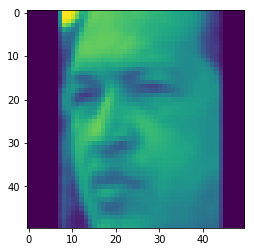

In [7]:
from scipy import ndimage

blured_images = [ndimage.uniform_filter(i,size=2) for i in X_padded]

plt.imshow(blured_images[0].reshape(50,50))
blured_images=np.array(blured_images)
blured_images.shape

In [8]:
# merging with original set

X_merged = np.append(X_padded,blured_images,axis=0)
print(X_merged.shape)

y_merged = np.append(y,y)
y_merged.shape

(2576, 1, 50, 50)


(2576,)

#### Raise contrast

(2576, 1, 50, 50)

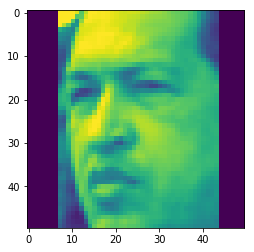

In [9]:
from skimage import exposure

v_min, v_max = np.percentile(X_padded[0], (1, 99))
better_contrast = [exposure.rescale_intensity(i, in_range=(v_min, v_max)) for i in X_merged]
better_contrast = np.array(better_contrast)
plt.imshow(better_contrast[0].reshape(50,50))
                                              
better_contrast.shape

In [10]:
X_merged_contrast = np.append(X_merged, better_contrast, axis=0)
print(X_merged_contrast.shape)

y_merged_contrast = np.append(y_merged,y_merged)
y_merged_contrast.shape

(5152, 1, 50, 50)


(5152,)

#### Flipping

(10304, 1, 50, 50)


(10304,)

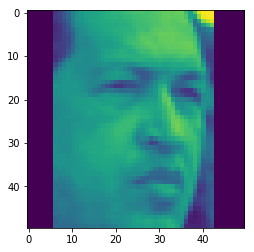

In [11]:
flipped_images = np.flip(X_merged_contrast, axis=-1)
plt.imshow(flipped_images[0].reshape(50,50))

# merging again
X_merged_flipping =  np.append(X_merged_contrast, flipped_images, axis=0)
print(X_merged_flipping.shape)

y_merged_flipping = np.append(y_merged_contrast,y_merged_contrast)
y_merged_flipping.shape

### Splitting, normalizing and randomizing the Dataset

In [12]:
from sklearn.model_selection import train_test_split
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X_merged_flipping, y_merged_flipping, test_size=0.25, random_state=42)

print("Traning:",X_train.shape,y_train.shape)
print("Test:",X_test.shape,y_test.shape)

Traning: (7728, 1, 50, 50) (7728,)
Test: (2576, 1, 50, 50) (2576,)


In [13]:
# shuffle training data
shuffle_index = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

print("train shapes:", X_train.shape, ", ", y_train.shape)
print("test shapes:", X_test.shape, ", ", y_test.shape)

train shapes: (7728, 1, 50, 50) ,  (7728,)
test shapes: (2576, 1, 50, 50) ,  (2576,)


In [14]:
print("max values", np.max(X_train))
print("max value", np.max(X_test))
print("min values", np.min(X_train))
print("min value", np.min(X_test))

max values 255.0
max value 255.0
min values 0.0
min value 0.0


In [15]:
# to get our matrix values inbetween 0 and 1
X_train /= 255
X_test /= 255
print("max values", np.max(X_train))
print("min value", np.max(X_test))

max values 1.0
min value 1.0


### Labels to binary vector - not needed

## Testing the modell on a different images

In [16]:
# design a three hidden layer architecture with Dense-Layer
# and ReLU as activation function
def fcn_lfw_test_relu():
    flat = Flatten()
    hidden_01 = FullyConnected(2500, 500)
    relu_01 = ReLU()
    hidden_02 = FullyConnected(500, 200)
    relu_02 = ReLU()
    hidden_03 = FullyConnected(200, 100)
    relu_03 = ReLU()
    ouput = FullyConnected(100, 7)
    return [flat, hidden_01, relu_01, hidden_02, relu_02, hidden_03, relu_03, ouput]

print("ReLU test")
# create a neural network on specified architecture with softmax as score function
fcn_relu = NeuralNetwork(fcn_lfw_test_relu(), score_func=LossCriteria.softmax)

# optimize the network and a softmax loss
fcn_relu = Optimizer.sgd(fcn_relu, X_train, y_train, LossCriteria.cross_entropy_softmax,
                    batch_size=64, epoch=5, learning_rate=0.0001, X_test=X_test,
                    y_test=y_test, verbose=True)

ReLU test
Epoch 1
Loss = 1.7642921146060209 :: Training = 0.40877329192546585 :: Test = 0.4281832298136646
Epoch 2
Loss = 1.7122906552542732 :: Training = 0.4311594202898551 :: Test = 0.45108695652173914
Epoch 3
Loss = 1.662724311983523 :: Training = 0.4442287784679089 :: Test = 0.46389751552795033
Epoch 4
Loss = 1.6093796405386458 :: Training = 0.4554865424430642 :: Test = 0.47437888198757766
Epoch 5
Loss = 1.5766709205892067 :: Training = 0.46299171842650105 :: Test = 0.4805900621118012


## Testing activation functions and optimizers

### Testing Leaky Relu and sgd_momentum + nesterov

In [17]:
# design a three hidden layer architecture with Dense-Layer
# and ReLU as activation function
def fcn_lfw():
    flat = Flatten()
    hidden_01 = FullyConnected(2500, 500)
    relu_01 = LeakyReLU()
    hidden_02 = FullyConnected(500, 200)
    relu_02 = LeakyReLU()
    hidden_03 = FullyConnected(200, 100)
    relu_03 = LeakyReLU()
    ouput = FullyConnected(100, 7)
    return [flat, hidden_01, relu_01, hidden_02, relu_02, hidden_03, relu_03, ouput]

print("Leaky Relu + sgd momentum test")
# create a neural network on specified architecture with softmax as score function
fcn_test_momentum = NeuralNetwork(fcn_lfw(), score_func=LossCriteria.softmax)
# optimize the network and a softmax loss
fcn_test_momentum = Optimizer.sgd_momentum(fcn_test_momentum, X_train, y_train, LossCriteria.cross_entropy_softmax,
                    batch_size=64, epoch=5, learning_rate=0.00005,mu=0.9, X_test=X_test,
                    y_test=y_test, verbose=True)
print("Leaky Relu + sgd nesterov test")
# create a neural network on specified architecture with softmax as score function
fcn_test_nest = NeuralNetwork(fcn_lfw(), score_func=LossCriteria.softmax)
fcn_test_nest = Optimizer.sgd_momentum(fcn_test_nest, X_train, y_train, LossCriteria.cross_entropy_softmax,
                    batch_size=64, epoch=5, learning_rate=0.00005,mu=0.9,nesterov = 1, X_test=X_test,
                    y_test=y_test, verbose=True)

Leaky Relu + sgd momentum test
Epoch 1
Loss = 1.8128794486714377 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076
Epoch 2
Loss = 1.8419666053513353 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076
Epoch 3
Loss = 1.9894783690213973 :: Training = 0.25789337474120083 :: Test = 0.27290372670807456
Epoch 4


/home/s0558366/abgabe/htw_nn_framework/loss_func.py:22: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -np.log(p[range(m), y])
/home/s0558366/abgabe/htw_nn_framework/loss_func.py:12: RuntimeWarning: invalid value encountered in subtract
  exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
/home/s0558366/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/s0558366/abgabe/htw_nn_framework/activation_func.py:61: RuntimeWarning: invalid value encountered in less_equal
  dX[self.X <= 0] = 0.01


Loss = nan :: Training = 0.061853002070393376 :: Test = 0.05357142857142857
Epoch 5
Loss = nan :: Training = 0.061853002070393376 :: Test = 0.05357142857142857
Leaky Relu + sgd nesterov test
Epoch 1
Loss = 1.832840612298952 :: Training = 0.23589544513457558 :: Test = 0.23486024844720496
Epoch 2
Loss = 1.8452374363522102 :: Training = 0.23796583850931677 :: Test = 0.2375776397515528
Epoch 3
Loss = 11.466733854508995 :: Training = 0.14635093167701863 :: Test = 0.13121118012422361
Epoch 4
Loss = nan :: Training = 0.061853002070393376 :: Test = 0.05357142857142857
Epoch 5
Loss = nan :: Training = 0.061853002070393376 :: Test = 0.05357142857142857


### Testing Sigmoid and adagrad + rmsprop

In [18]:
# design a three hidden layer architecture with Dense-Layer
# and ReLU as activation function
def fcn_lfw():
    flat = Flatten()
    hidden_01 = FullyConnected(2500, 500)
    relu_01 = sigmoid()
    hidden_02 = FullyConnected(500, 200)
    relu_02 = sigmoid()
    hidden_03 = FullyConnected(200, 100)
    relu_03 = sigmoid()
    ouput = FullyConnected(100, 7)
    return [flat, hidden_01, relu_01, hidden_02, relu_02, hidden_03, relu_03, ouput]

print("sigmoid + adagrad")
# create a neural network on specified architecture with softmax as score function
fcn_test_adagrad = NeuralNetwork(fcn_lfw(), score_func=LossCriteria.softmax)
# optimize the network and a softmax loss
fcn_test_adagrad = Optimizer.adagrad(fcn_test_adagrad, X_train, y_train, LossCriteria.cross_entropy_softmax,
                                     batch_size=64, epoch=5, learning_rate=0.00001, X_test=X_test,
                                     y_test=y_test, verbose=True)
print("sigmoid + rmsprop")
# create a neural network on specified architecture with softmax as score function
fcn_test_rms = NeuralNetwork(fcn_lfw(), score_func=LossCriteria.softmax)
fcn_test_rms = Optimizer.rmsprop(fcn_test_rms, X_train, y_train, LossCriteria.cross_entropy_softmax,
                                 batch_size=64, epoch=5, learning_rate=0.0005, X_test=X_test,
                                 y_test=y_test, verbose=True)

sigmoid + adagrad
Epoch 1
Loss = 2.220227056759286 :: Training = 0.09161490683229814 :: Test = 0.10093167701863354
Epoch 2
Loss = 2.1956477422859404 :: Training = 0.09161490683229814 :: Test = 0.10093167701863354
Epoch 3
Loss = 2.1774976114393336 :: Training = 0.09161490683229814 :: Test = 0.10093167701863354
Epoch 4
Loss = 2.162672999850233 :: Training = 0.09161490683229814 :: Test = 0.10093167701863354
Epoch 5
Loss = 2.1499704726110878 :: Training = 0.09161490683229814 :: Test = 0.10093167701863354
sigmoid + rmsprop
Epoch 1
Loss = 1.8121063263608697 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076
Epoch 2
Loss = 1.8139918299076767 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076
Epoch 3
Loss = 1.8139953975941019 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076
Epoch 4
Loss = 1.813995404857998 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076
Epoch 5


/home/s0558366/abgabe/htw_nn_framework/optimizer.py:176: RuntimeWarning: overflow encountered in square
  grad_squared[i] = [mu * temp[0] + (1 - mu) * grad[0] ** 2, mu * temp[1] + (1 - mu) * grad[1] ** 2]


Loss = 1.8139954048747349 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076


### Testing tan hyperbolic and adadelta + adam

In [19]:
# design a three hidden layer architecture with Dense-Layer
# and ReLU as activation function
def fcn_lfw():
    flat = Flatten()
    hidden_01 = FullyConnected(2500, 500)
    relu_01 = tanh()
    hidden_02 = FullyConnected(500, 200)
    relu_02 = tanh()
    hidden_03 = FullyConnected(200, 100)
    relu_03 = tanh()
    ouput = FullyConnected(100, 7)
    return [flat, hidden_01, relu_01, hidden_02, relu_02, hidden_03, relu_03, ouput]


print("tanh + adadelta")
# create a neural network on specified architecture with softmax as score function
fcn_test_adadelta = NeuralNetwork(fcn_lfw(), score_func=LossCriteria.softmax)
# optimize the network and a softmax loss
fcn_test_adadelta = Optimizer.adadelta(fcn_test_adadelta, X_train, y_train, LossCriteria.cross_entropy_softmax,
                    batch_size=64, epoch=5,mu=0.1,learning_rate=1, X_test=X_test,
                    y_test=y_test, verbose=True)

print("tanh + adam")
#create a neural network on specified architecture with softmax as score function
fcn_test_adam = NeuralNetwork(fcn_lfw(), score_func=LossCriteria.softmax)
fcn_test_adam = Optimizer.adam(fcn_test_adam, X_train, y_train, LossCriteria.cross_entropy_softmax,
                    batch_size=64, epoch=5,learning_rate=0.01, X_test=X_test,
                    y_test=y_test, verbose=True)

tanh + adadelta
Epoch 1
Loss = 2.149985741955899 :: Training = 0.09174430641821946 :: Test = 0.10093167701863354
Epoch 2
Loss = 2.2665849429872424 :: Training = 0.0552536231884058 :: Test = 0.054736024844720496
Epoch 3
Loss = 2.1608318264886557 :: Training = 0.0552536231884058 :: Test = 0.054736024844720496
Epoch 4
Loss = 2.0338670822594973 :: Training = 0.0552536231884058 :: Test = 0.054736024844720496
Epoch 5
Loss = 2.0127773292784377 :: Training = 0.1873706004140787 :: Test = 0.17080745341614906
tanh + adam
Epoch 1
Loss = 1.8393870196367974 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076
Epoch 2
Loss = 1.8321604091705712 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076
Epoch 3
Loss = 1.847179311196075 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076
Epoch 4
Loss = 1.8444621606990055 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076
Epoch 5
Loss = 1.8399830219328746 :: Training = 0.4067028985507246 :: Test = 0.42585403726708076


## Conv + Pooling Layer Test

### MNIST test

In [23]:
# design a three hidden layer architecture with Dense-Layer
# and ReLU as activation function
def fcn_conv_test():
    conv_01 = Conv(1, 16, (3, 3), stride=2, padding=0)
    conv_02 = Conv(16, 32, (3, 3), stride=2, padding=0)
    max_pooling = Pool()
    flat = Flatten()
    hidden_01 = FullyConnected(288, 500)
    relu_03 = ReLU()
    hidden_02 = FullyConnected(500, 200)
    relu_04 = ReLU()
    hidden_03 = FullyConnected(200, 100)
    relu_05 = ReLU()
    ouput = FullyConnected(100, 10)
    return [conv_01, conv_02, max_pooling, flat, hidden_01, relu_03, hidden_02, relu_04, hidden_03, relu_05, ouput]


# create a neural network on specified architecture with softmax as score function
fcn_conv_test_1 = NeuralNetwork(fcn_conv_test(), score_func=LossCriteria.softmax)

# optimize the network and a softmax loss
fcn_conv_test_1 = Optimizer.adam(fcn_conv_test_1, train_images, train_labels, LossCriteria.cross_entropy_softmax, batch_size=64,
                    epoch=5, learning_rate=0.001, X_test=test_images, y_test=test_labels, verbose=True)

Epoch 1
Loss = 0.2743135238607054 :: Training = 0.9368666666666666 :: Test = 0.932
Epoch 2
Loss = 0.2914166543963353 :: Training = 0.9101333333333333 :: Test = 0.9007
Epoch 3
Loss = 0.25938087895090395 :: Training = 0.95675 :: Test = 0.9465
Epoch 4
Loss = 0.2599325501559736 :: Training = 0.9345166666666667 :: Test = 0.9202
Epoch 5
Loss = 0.2879404094865853 :: Training = 0.9601 :: Test = 0.9477


### LFW test

In [24]:
# design a three hidden layer architecture with Dense-Layer
# and ReLU as activation function
def fcn_conv_test():
    conv_01 = Conv(1, 16, (3, 3), stride=2, padding=0)
    conv_02 = Conv(16, 32, (3, 3), stride=2, padding=0)
    max_pooling = Pool()
    flat = Flatten()
    hidden_01 = FullyConnected(800, 500)
    relu_03 = ReLU()
    hidden_02 = FullyConnected(500, 200)
    relu_04 = ReLU()
    hidden_03 = FullyConnected(200, 100)
    relu_05 = ReLU()
    ouput = FullyConnected(100, 7)
    return [conv_01, conv_02, max_pooling, flat, hidden_01, relu_03, hidden_02, relu_04, hidden_03, relu_05, ouput]


# create a neural network on specified architecture with softmax as score function
fcn_conv_test_2 = NeuralNetwork(fcn_conv_test(), score_func=LossCriteria.softmax)

# optimize the network and a softmax loss
fcn_conv_test_2 = Optimizer.adam(fcn_conv_test_2, X_train, y_train, LossCriteria.cross_entropy_softmax, batch_size=64,
                    epoch=5, learning_rate=0.001, X_test=X_test, y_test=y_test, verbose=True)

Epoch 1
Loss = 1.644578362550402 :: Training = 0.4531573498964803 :: Test = 0.47127329192546585
Epoch 2
Loss = 1.52452577302513 :: Training = 0.5106107660455487 :: Test = 0.515527950310559
Epoch 3
Loss = 1.4533093404521764 :: Training = 0.5182453416149069 :: Test = 0.5178571428571429
Epoch 4
Loss = 1.3255074967568865 :: Training = 0.5520186335403726 :: Test = 0.5566770186335404
Epoch 5
Loss = 1.2646599273461587 :: Training = 0.5646997929606625 :: Test = 0.5648291925465838


## Dropout layer test

### MNIST test 


In [25]:
# design a three hidden layer architecture with Dense-Layer
# and ReLU as activation function
def fcn_presentation():
    conv_01 = Conv(1, 32, (3, 3), stride=1, padding=0)
    conv_02 = Conv(32, 64, (3, 3), stride=1, padding=0)
    max_pool = Pool()
    dropout_01 = Dropout(0.25)
    flat = Flatten()
    hidden_01 = FullyConnected(784, 128)
    relu_03 = ReLU()
    dropout_02 = Dropout()
    output = FullyConnected(128, 10)
    return [dropout_01, flat, hidden_01, relu_03, dropout_02, output]
#conv_01, conv_02, max_pool, 

# create a neural network on specified architecture with softmax as score function
fcn_presentation = NeuralNetwork(
    fcn_presentation(), score_func=LossCriteria.softmax)
# optimize the network and a softmax loss
fcn_presentation = Optimizer.adam(fcn_presentation, train_images, train_labels, LossCriteria.cross_entropy_softmax, batch_size=128,
                                 epoch=5, learning_rate=0.001, X_test=test_images, y_test=test_labels, verbose=True)

Epoch 1
Loss = 0.6814850858774942 :: Training = 0.7379833333333333 :: Test = 0.7441
Epoch 2
Loss = 0.5632370103166591 :: Training = 0.7699 :: Test = 0.7736
Epoch 3
Loss = 0.575874269619538 :: Training = 0.7875833333333333 :: Test = 0.7933
Epoch 4
Loss = 0.615551496582052 :: Training = 0.8014833333333333 :: Test = 0.801
Epoch 5
Loss = 0.5483758213837259 :: Training = 0.8096166666666667 :: Test = 0.8161


### LFW test

In [26]:
# design a three hidden layer architecture with Dense-Layer
# and ReLU as activation function
def fcn_presentation():
    conv_01 = Conv(1, 32, (3, 3), stride=2, padding=0)
    conv_02 = Conv(32, 64, (3, 3), stride=2, padding=0)
    max_pool = Pool()
    dropout_01 = Dropout(0.25)
    flat = Flatten()
    hidden_01 = FullyConnected(1600, 128)
    relu_03 = ReLU()
    dropout_02 = Dropout()
    output = FullyConnected(128, 7)
    return [conv_01, conv_02, max_pool, dropout_01, flat, hidden_01, relu_03, dropout_02, output]

# create a neural network on specified architecture with softmax as score function
fcn_presentation_lfw = NeuralNetwork(
    fcn_presentation(), score_func=LossCriteria.softmax)
# optimize the network and a softmax loss
fcn_presentation_lfw = Optimizer.rmsprop(fcn_presentation_lfw, X_train, y_train, LossCriteria.cross_entropy_softmax, batch_size=64,
                                 epoch=10, learning_rate=0.001, X_test=X_test, y_test=y_test, verbose=True)

Epoch 1
Loss = 1.9841268504094753 :: Training = 0.4001035196687371 :: Test = 0.4169254658385093
Epoch 2
Loss = 1.8589618902247143 :: Training = 0.4048913043478261 :: Test = 0.421972049689441
Epoch 3
Loss = 1.8005494131730277 :: Training = 0.40372670807453415 :: Test = 0.42274844720496896
Epoch 4
Loss = 1.780875084039959 :: Training = 0.40515010351966874 :: Test = 0.42430124223602483
Epoch 5
Loss = 1.7819372174673085 :: Training = 0.4065734989648033 :: Test = 0.42430124223602483
Epoch 6
Loss = 1.7867720699996952 :: Training = 0.40631469979296064 :: Test = 0.4254658385093168
Epoch 7
Loss = 1.761214503805375 :: Training = 0.40618530020703936 :: Test = 0.42585403726708076
Epoch 8
Loss = 1.7842623999533085 :: Training = 0.40631469979296064 :: Test = 0.4254658385093168
Epoch 9
Loss = 1.7857556206464276 :: Training = 0.40631469979296064 :: Test = 0.42507763975155277
Epoch 10
Loss = 1.7869621345392048 :: Training = 0.40618530020703936 :: Test = 0.4254658385093168


## Batchnorm layer test